# In which I brazenly defy Professor Ng and do his Support Vector Machine homework in Python instead of Matlab.

Week 7 of Andrew Ng's ML course on Coursera introduces the Support Vector Machine algorithm for classification and discusses Kernels which generate new features for this algorithm. Here I use the homework data set to learn about the relevant python tools.

>## Tools Covered:
- `LinearSVC` for classification using a linear kernel and specifying choice of loss
- `SVC` for classification specifying your choice of kernel and using "hinge" loss
- `StandardScaler` for scaling your data before fitting - very important for SVMs
- `validation_curve` for generating diagnostic plots of score vs. meta-parameter value
- `GridSearchCV` for exhaustively searching a meta-parameter space for optimal values
- also visualizing non-linear decision boundaries

In [2]:
# Set up environment
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle

import snips as snp  # my snippets
snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

In [3]:
cd hw-wk7

C:\Users\Sonya\Box Sync\Projects\course-machine-learning\hw-wk7


# Quick Look at the Data
From Professor Ng's homework: *"...you will be using support vector machines
(SVMs) with various example 2D datasets...you will be using support
vector machines to build a spam classifier."*

In [4]:
# Read in all my data sets
with open("wk6_data.pickle", "rb") as myfile:
    X1, X2, X3, y1, y2, y3 = pickle.load(myfile)

Xs, ys = [X1, X2, X3], [y1, y2, y3]

## Scale the Data for SVMs!
Since the SVM fitting algorithm is very sensitive to feature scaling, let's just get that out of the way right from the start. We'll use the sklearn preprocessor `StandardScaler`

In [5]:
# Scale all my data, makes numerical loss-minimization easier
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

for i in np.arange(0, 3, 1):
    scaler.fit(Xs[i])
    Xs[i] = scaler.transform(Xs[i])
    
X1, X2, X3 = Xs
y1, y2, y3 = ys

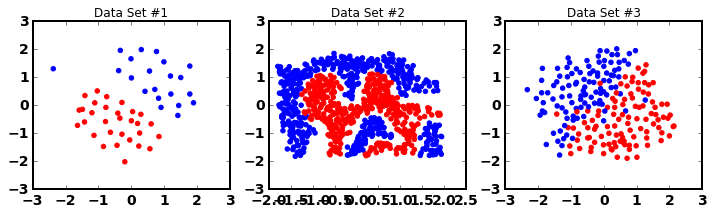

In [76]:
# Visualize the three different sets
fig, axs = plt.subplots(figsize=[12, 3], nrows=1, ncols=3, sharex=False, sharey=False)

for i in np.arange(0, 3, 1):
    axs[i].scatter(Xs[i][:, 0], Xs[i][:, 1], color=["r" if y == 0 else "b" for y in ys[i]])
    axs[i].set_title("Data Set #%i" % (i+1,))

All these data live in $R^2$ and are labeled either 0 (blue) or 1 (red). We want to see what a Support Vector Machine can do to classify each of these rather different data sets. Notice the middle set has both a very complicated decision boundary - we would expect to have issues with overfitting if we attempted to model this boundary with very few data points but here we have quite a lot. Also notice the far left outlier in the first Data Set #1

# Quick Review of SVMs
Support Vector Machine is a supervised algorithm that involves new feature creation, via kernel functions on $x$, in a computationally feasible way. The creation of new features allows training points to be cast into a higher dimensional space where the label groups are more readily separable. SVMs are "Large Margin Classifiers" meaning they fit decision boundaries which give the widest berth between the boundary and the nearest points of each class.

### SVM From Logistic Regression
The simplest SVM can be constructed by modifying the logistic regression procedure as follows: the log loss cost function is replaced by the "Hinge Loss": a similar-shaped piecewise curve which is a flat line at 0 joined (at $z=\pm1$ for $y=1,0$ cost) to a straight line with a finite slope, and the hypothesis is replaced with a binary 0 or 1 output rather than a probability on $[0, 1]$. With these modifications we get the "Linear Kernel" SVM and naturally it behaves very similarly to logistic regression. This graph from [Cornell lecture notes](http://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/lecturenote10.html) compares Hinge and Logistic loss (as well as a few others) for the $y=1$ case.

<img src=images/hw-wk7/classificationlosses.png width=400></img>

### Kernels for New Features
The true power of SVMs is to incorporate new feature creation via similarity transforms while maintaing computational feasibility. **A similarity transform of your input $x$ is a function that returns its "similarity" to some fixed "landmark" point, $l^{(i)}$, in feature space. The similarity transform can have lots of different functional forms which are called kernels.** Here is an example with a Gaussian kernel, which has value 1 at the landmark and decays as you move away radially:

\begin{align*}
\textrm{new feature } \qquad f_1 = \textrm{similarity}(x, l^{(1)})\\
\textrm{for example,} \qquad f_1 = exp(- \frac{ ||x - l^{(1)}||^2}{2\sigma^2}) = k_{gauss}(x, l^{(1)}).
\end{align*} 

This screen capture from Professor Ng's Coursera course slides gives a good illustration.

<img src=images/hw-wk7/pic20.png width=500></img>

We can choose as many landmarks and thus construct as many of these new features as we like. The kernel maps our our input feaures, $x$, to our new transformed features, $f$, which each reflect $x$'s similarity to a specific landmark point. For any point close to the $j^{th}$ landmark, all values of $f_{i\neq j}$ will be near zero, while $f_j \approx 1$ and thus $z\approx \theta_j$. For this reason the decision boundary will be drawn to encompass landmarks whose corresponding weight $\theta_i$ is positive, tending to give $z>0$ and thus outputting the prediction $y=1$.

### Full Specification of an SVM
\begin{align*}
f^{(i)} = \textrm{sim}(x, l^{(i)})\\
\\
h^{SVM}_\theta(x) = \left\{
        \begin{array}{ll}
            1 & \theta^Tf \geq 0 \\
            0 & \textrm{otherwise}
        \end{array}
    \right.
\\
\\
\textrm{cost}_1(z) = max(0, k(z+1))\\
\textrm{cost}_0(z) = max(0, k(z-1))\\
z=\theta^Tf, \qquad k=\textrm{slope}
\\
\\
J_\theta^{SVM} = C\sum_{i=1}^m \bigg[y^icost_1(\theta^Tf) + (1-y^i)cost_0(\theta^Tf)\bigg] + \theta^T \mathbf{M} \theta,
\end{align*}

You can see that there are a few other changes in convention as compared to logistic regression. Instead of $\lambda$ weighting the regularization term we have $C$ weighting the data term, we don't divide by the number of training points $m$, and we use a penalty $\theta^T M \theta$ for some matrix of $M$ that depends on the kernel and this gives a slightly different distance metric.

# SVMs in Scikit-learn

Linear Kernel SVM for classification is implemented in sklearn via the class `LinearSVC`, while the class that supports classification with more complicated kernels is simply `SVC`.

These tools support multi-class classification but note that `SVC` is using a "one-vs-one" approach while `LinearSVC` uses the more familiar "one-vs-all".
- **OVA**: train $K$ classifiers: a binary classifier for each class, with the samples of that class as positive samples and all other samples as negatives. For prediciton choose the class whose classifier outputs the largest value .
- **OVO**: train $\frac{K(K − 1)}{2}$ classifiers: each binary classifier corresponding to a particular pair of classes.  receives the samples of a pair of classes from the original training set, and must learn to distinguish these two classes. For prediction choose the class who wins the most of its pair-wise matchups. 

# Linear Kernel SVM 
Linear kernel SVMs are appropriate in places where logistic regression would be appropriate. For Data Set #1, by eye it is already linearly separable in $x$-space so we do not need to rely on transforms (kernels) to broadcast the data into a higher dimensional space in order to make it separable - this means the linear kernel will do fine.

Lets try `LinearSVC` with the standard `loss=hinge` I described above. A critical parameter for your SVM is, `C`, the weighting that the data term (not the regularization term) receives in the loss function. **You can think of `C` as the inverse of regularization strength so it controls the bias/variance tradeoff of your SVM, and in particular it dictates how sensitive the decision boundary is to outliers.**

As with most estimator classes in sklearn, you `fit` and then you can `predict`. I'll try both a low and high value for `C`.

In [77]:
from sklearn.svm import LinearSVC

# Make and fit my SVM with low `C`
svm_bias = LinearSVC(loss="hinge", C=1.0)
svm_bias.fit(X1, y1)

# Make and fit my SVM with low `C`
svm_variance = LinearSVC(loss="hinge", C=100)
svm_variance.fit(X1, y1)

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [78]:
# Look at the fitted parameters theta
svm_bias.coef_, svm_bias.intercept_

(array([[ 1.32937495,  1.84951496]]), array([-0.56514193]))

### Visualizing Linear Decision Boundary
With the linear Kernel the decision boundary in $x$-space is the line $z=\theta^Tx = 0$ that divides the two half-spaces where we predict $y=1$ and $y=0$, respectively. Let's visualize this boundary on top of our data:

In [79]:
# Make Line Values from the decision boundary lines
x1s = np.linspace(min(X1[:, 0]), max(X1[:, 0]), 20)
x2s_bias = (-svm_bias.intercept_ - svm_bias.coef_[0][0]*x1s)/svm_bias.coef_[0][1]
x2s_variance = (-svm_variance.intercept_ - svm_variance.coef_[0][0]*x1s)/svm_variance.coef_[0][1]

# Visualize the decision boundary
fig, ax = plt.subplots()
ax.scatter(X1[:, 0], X1[:, 1], color=["r" if y == 0 else "b" for y in y1])
ax.plot(x1s, x2s_bias, linestyle="--", label="low C, high bias")
ax.plot(x1s, x2s_variance, linestyle="--", label="high C, high variance")
ax.legend(loc="lower left")
ax.set_title("Data Set #%i" % (i+1,))

Weighting the data term heavily in the loss has resulted in forcing the decision boundary to correctly incorporate the lone outlier, even though to by eye it is a less appropriate dividing line. 

# Gaussian Kernel SVM 
For Data Set #2 it is clear that a linear decision boundary in $x$-space is not sufficient, so we will transform our data into a higher dimensional space in which it *is* linearly separable. The `kernel` kwarg specifies the particular transform, and since most kernels are themselves parameterized by some parameter $\gamma$, you need to also pass this with the `gamma` kwarg. The Guassian kernel here goes by the string `"rbf"`, and the `gamma="auto"` will give you a reasonable value of $1/n$ where $n$ is the number of features. Also note you can't specify the loss for Kernel SVC, it must be "Hinge", otherwise the tricks that make the transforms feasible will break down.

Just as with Linear Kernel SVM, the `C` kwarg controls the bias/variance tradeoff AKA the amount of underfitting or overfitting. Let's see the effect of small `C` and large `C`.

In [433]:
from sklearn.svm import SVC

# Make and fit SVMs with Gaussian Kernel
svm_bias = SVC(kernel="rbf", gamma="auto", C=1)
svm_bias.fit(X2, y2)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [434]:
svm_var = SVC(kernel="rbf", gamma="auto", C=1e6)       
svm_var.fit(X2, y2)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We expect the high-variance overfit model to perform almost perfectly on the data it was trained on, while the high-bias underfit model should do poorly even on the training set. We can check this intuition with the `score` method which returns the mean accuracy for classifying data $(X, y)$. 

In [435]:
svm_bias.score(X2, y2), svm_var.score(X2, y2)

(0.90498261877172659, 1.0)

### Visualizing Non-Linear Decision Boundary
With any non-linear Kernel the decision boundary in the transformed higher-dimensional feature-space ($x \rightarrow f$) is the line $z=\theta^Tf = 0$ that divides the two half-spaces where we predict $y=1$ and $y=0$, respectively. This "line" in the higher dimensional feature space will be a more complicated boundary shape when projected back down to the real-world $x$-space, so how can we visualize it? 

Here is one strategy: make a dense grid of points in the your $x$ space, call `SVM.decision_function` to get each points value of $\theta^Tf$, and plot the points in $x$-space who have $\theta^Tf \approx 0$.

In [436]:
# Generate a set of points that form a grid over feature space
x1s = np.linspace(min(X2[:, 0]), max(X2[:, 0]), 600)
x2s = np.linspace(min(X2[:, 1]), max(X2[:, 1]), 600)
points = np.array([[x1, x2] for x1 in x1s for x2 in x2s])

# Compute decision function for each point, keep those which are close to the boundary
dist_bias = svm_bias.decision_function(points)
bounds_bias = np.array([pt for pt, dist in zip(points, dist_bias) if abs(dist)<0.05])

dist_var = svm_var.decision_function(points)
bounds_var = np.array([pt for pt, dist in zip(points, dist_var) if abs(dist)<0.05])

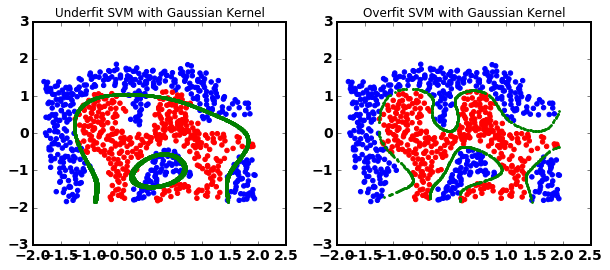

In [437]:
# Visualize the decision boundary
fig, [ax1, ax2] = plt.subplots(figsize=[10, 4], nrows=1, ncols=2)

ax1.scatter(X2[:, 0], X2[:, 1], color=["r" if y == 0 else "b" for y in y2], label="data")
ax1.scatter(bounds_bias[:, 0], bounds_bias[:, 1], color="g", s=3, label="decision boundary")
ax1.set_title("Underfit SVM with Gaussian Kernel")

ax2.scatter(X2[:, 0], X2[:, 1], color=["r" if y == 0 else "b" for y in y2], label="data")
ax2.scatter(bounds_var[:, 0], bounds_var[:, 1], color="g", s=3, label="decision boundary")
ax2.set_title("Overfit SVM with Gaussian Kernel")

# Optimizing Meta-Parameters 
The first two data sets were idealized, so we were easily able to get a decision boundary that completely separated our classes without running any danger of overfitting. The third data set more closely resembles a real world set and gives us a chance to practice "model selection" or choosing the meta-parameters of our model to optimize the eternal bias-variance trade off. 

We can systematically explore the effect of a *single* meta-parameter (all others being fixed) with `validation_curve` which I've written about [here](http://sdsawtelle.github.io/blog/output/week6-andrew-ng-machine-learning-with-python.html). With multiple meta parameters, like `C` and `gamma` in this case, you'll need to search over a multi-dimensional parameter space or "grid", and `GridSearchCV` is just the tool! 

## Choosing `C` and `Gamma` With a Grid Search
The most critical thing to pass to the grid search is the dictionary of parameters and their value ranges. Two things to keep in mind are: 

1. `GridSearchCV` uses cross-validation (default is 3-fold) to score your model performance, so that each set of specific parameter values gives you three different error calculations that are averaged in order to get a smoother average behavior of error over the parameter space. 
2.  What exactly is the "error" here? In `GridSearchCV` if you don't provide the `scoring` kwarg then it will check if your estimator has a scoring method defined. In this case `SVC` implements `score` as *mean accuracy of classification*.

In [490]:
from sklearn.model_selection import GridSearchCV

# Create my estimator and prepare the parameter grid dictionary
params_dict = {"C": np.logspace(-1, 3, 100), "gamma": np.linspace(0.0001, 10, 100)}
svm = SVC(kernel="rbf")

# Fit the grid search
search = GridSearchCV(estimator=svm, param_grid=params_dict)
search.fit(X3, y3)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.09750e-01, ...,   9.11163e+02,   1.00000e+03]), 'gamma': array([  1.00000e-04,   1.01109e-01, ...,   9.89899e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

You can use the `GridSearchCV` object like an estimator: after fitting it exposes methods like `predict` and `score` corresponding to the estimator with the optimal meta-parameter values it found. You can also inspect the results of the grid search with a few key attributes of the class:

In [487]:
print("Best parameter values:", search.best_params_)
print("CV Score with best parameter values:", search.best_score_)

Best parameter values: {'C': 25.595479226995359, 'gamma': 0.89806122448979597}
CV Score with best parameter values: 0.905213270142


The full results can be read into a dataframe from attribute `cv_results_`:

In [488]:
df = pd.DataFrame(search.cv_results_)
df.head()

mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.002659         0.004000         0.635071          0.675937       1   
1       0.001334         0.004002         0.838863          0.907531       1   
2       0.008001         0.004000         0.834123          0.914657       1   
3       0.002676         0.001334         0.829384          0.924198       1   
4       0.002658         0.000000         0.834123          0.928926       1   

  param_gamma                                params  rank_test_score  \
0       0.001            {'C': 1.0, 'gamma': 0.001}             2500   
1   0.0213878   {'C': 1.0, 'gamma': 0.021387755102}             2378   
2   0.0417755  {'C': 1.0, 'gamma': 0.0417755102041}             2406   
3   0.0621633  {'C': 1.0, 'gamma': 0.0621632653061}             2443   
4    0.082551  {'C': 1.0, 'gamma': 0.0825510204082}             2406   

   split0_test_score  split0_train_score  split1_test_score  \
0           0.901408            0.921429           0.500000   
1           0.901408            0.885714           0.928571   
2           0.901408            0.900000           0.914286   
3           0.901408            0.935714           0.914286   
4           0.901408            0.935714           0.928571   

   split1_train_score  split2_test_score  split2_train_score  std_fit_time  \
0            0.503546           0.500000            0.602837      0.001880   
1            0.907801           0.685714            0.929078      0.001886   
2            0.914894           0.685714            0.929078      0.005658   
3            0.914894           0.671429            0.921986      0.001892   
4            0.914894           0.671429            0.936170      0.001879   

   std_score_time  std_test_score  std_train_score  
0        0.000002        0.189669         0.178259  
1        0.000003        0.108477         0.017704  
2        0.003266        0.104701         0.011872  
3        0.001886        0.111419         0.008643  
4        0.000000        0.115170         0.009924

Let's capture the best-performing SVM from the parameter grid and use visualize it's decision boundary:

In [489]:
# Capture and fit the best estimator from across the grid search
best_svm = search.best_estimator_
best_svm.fit(X3, y3)

# Compute decision function for each point, keep those which are close to the boundary
dists = best_svm.decision_function(points)
bounds = np.array([pt for pt, dist in zip(points, dists) if abs(dist)<0.05])

# Visualize the decision boundary
fig, ax = plt.subplots()

ax.scatter(X3[:, 0], X3[:, 1], color=["r" if y == 0 else "b" for y in y3], label="data")
ax.scatter(bounds[:, 0], bounds[:, 1], color="g", s=3, label="decision boundary")
ax.set_title("Grid-Search Optimized SVM")

This is quite good, almost what a human would draw. It doesn't get too caught up in the messiness at the rough boundary between the two classes, but it does give one macroscopic "wiggle" which seems well justified to my eye. 

# In Summary:
SVM is a supervised algorithm that permits new feature creation, via kernel functions on $x$, in a computationally feasible way. The creation of new features allows training points to be cast into a higher dimensional hyperspace where the labels are more readily separable. SVM with a Linear Kernel behaves very much like to logistic regression, it is implemented in `LinearSVC` where you can specify you desired loss. SVM with more complicated kernels are implemented in `SVC` where you must use the "hinge" loss but you can specify the kernel. The most important meta-parameter of SVMs is the inverse regularization strength, `C` that impacts the bias/variance tradeoff: you can optimize this by plotting `validation_curve` but if you are using a kernel parameterized by $\gamma$ then you'll want to use `GridSearchCV` to optimize over the product space of `C` and $\gamma$.